In [31]:
# MSCI 546 Project:

# Link to the original Kaggle Competition (Real Dataset): https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction

In [32]:

# Libraries

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.optim as optim  # Optimization module

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [33]:
# Synthetic Dataset: https://www.kaggle.com/competitions/playground-series-s4e1/data

# Dataset import
import os
# Set directory to project root
os.chdir('/Users/danazarezankova/Documents/BME 2024/BME 4B/MSCI 546/msci-546-proj')

# Back to root directory
synthetic_train_data = pd.read_csv('data/train.csv')

synthetic_train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [34]:
# Label encoding for text data:
encoder = LabelEncoder()
categorical_features_train = synthetic_train_data.select_dtypes(include = 'object').columns
print("Categorical features: ", categorical_features_train)
for feature in categorical_features_train:
    synthetic_train_data[feature] = encoder.fit_transform(synthetic_train_data[feature])

# MinMax Scaler for credit score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
synthetic_train_data['CreditScore'] = scaler.fit_transform(synthetic_train_data[['CreditScore']])

# Robust Scaler for Balance
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
synthetic_train_data['Balance'] = scaler.fit_transform(synthetic_train_data[['Balance']])

# MinMax Scaler for Estimated Salary
scaler = MinMaxScaler()
synthetic_train_data['EstimatedSalary'] = scaler.fit_transform(synthetic_train_data[['EstimatedSalary']])

# Age / 100
synthetic_train_data['Age'] = synthetic_train_data['Age'] / 100

synthetic_train_data.drop('id', axis=1, inplace=True)
synthetic_train_data.drop('CustomerId', axis=1, inplace=True)
synthetic_train_data.drop('Surname', axis=1, inplace=True)
synthetic_train_data.dropna(inplace=True)

X = synthetic_train_data.drop('Exited', axis=1)
y = synthetic_train_data['Exited']


Categorical features:  Index(['Surname', 'Geography', 'Gender'], dtype='object')


In [35]:
X.describe()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,0.612909,0.648545,0.564429,0.381259,5.020353,0.462551,1.554455,0.753954,0.497770,0.562870
std,0.160207,0.816574,0.495833,0.088672,2.806159,0.523745,0.547154,0.430707,0.499997,0.251488
min,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.494000,0.000000,0.000000,0.320000,3.000000,0.000000,1.000000,1.000000,0.000000,0.373166
50%,0.618000,0.000000,1.000000,0.370000,5.000000,0.000000,2.000000,1.000000,0.000000,0.589738
75%,0.720000,1.000000,1.000000,0.420000,7.000000,1.000000,2.000000,1.000000,1.000000,0.775779
max,1.000000,2.000000,1.000000,0.920000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000


In [36]:
# Convert the data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
model = nn.Sequential(
    nn.Linear(10, 20), # 8 input nodes to 12 nodes in the first hidden layer
    nn.ReLU(),        # ReLU activation for first hidden layer
    nn.Linear(20, 10), # 12 nodes from first hidden layer to 8 in the second
    nn.ReLU(),        # ReLU activation for second hidden layer
    nn.Linear(10, 1),  # 8 nodes from second hidden layer to 1 output node
    nn.Sigmoid()      # Sigmoid activation for output layer
)

In [39]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [40]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.4591294825077057, accuracy 0.7884011779390914
Finished epoch 0, latest loss 0.4591294825077057
Finished epoch 1, latest loss 0.41841432452201843
Finished epoch 2, latest loss 0.39631396532058716
Finished epoch 3, latest loss 0.374592125415802
Finished epoch 4, latest loss 0.36128365993499756
Finished epoch 5, latest loss 0.3555643558502197
Finished epoch 6, latest loss 0.3522562086582184
Finished epoch 7, latest loss 0.34870970249176025
Finished epoch 8, latest loss 0.3454146981239319
Finished epoch 9, latest loss 0.3407660722732544
Epoch 10, loss 0.33694374561309814, accuracy 0.8406691954385157
Finished epoch 10, latest loss 0.33694374561309814
Finished epoch 11, latest loss 0.33349156379699707
Finished epoch 12, latest loss 0.32876870036125183
Finished epoch 13, latest loss 0.32311201095581055
Finished epoch 14, latest loss 0.3185547888278961
Finished epoch 15, latest loss 0.3149762749671936
Finished epoch 16, latest loss 0.31245100498199463
Finished epoch 17, latest 

In [41]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = y_pred_test.round().detach().numpy()
  
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_test)

In [42]:
print(f'Accuracy of the shallow NN model: {accuracy}')

Accuracy of the model: 0.8622413427454783


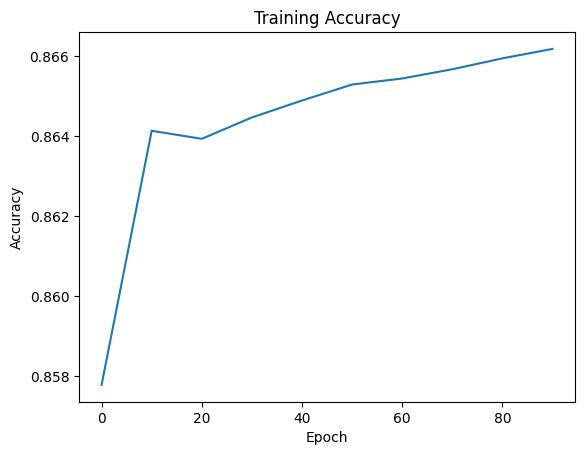

In [56]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Shallow Net Training Accuracy')
plt.show()

In [42]:
# Increase model width and depth

In [44]:
model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.ReLU(),   
    nn.Linear(20, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),   
    nn.Linear(20, 10), 
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

In [45]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [46]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.35122647881507874, accuracy 0.836694256940994
Finished epoch 0, latest loss 0.35122647881507874
Finished epoch 1, latest loss 0.3249504268169403
Finished epoch 2, latest loss 0.30679085850715637
Finished epoch 3, latest loss 0.3033575415611267
Finished epoch 4, latest loss 0.3009604215621948
Finished epoch 5, latest loss 0.3028038442134857
Finished epoch 6, latest loss 0.3005863428115845
Finished epoch 7, latest loss 0.298362672328949
Finished epoch 8, latest loss 0.3002917170524597
Finished epoch 9, latest loss 0.30261778831481934
Epoch 10, loss 0.2999499440193176, accuracy 0.8609498648763285
Finished epoch 10, latest loss 0.2999499440193176
Finished epoch 11, latest loss 0.30280357599258423
Finished epoch 12, latest loss 0.300001323223114
Finished epoch 13, latest loss 0.3003483712673187
Finished epoch 14, latest loss 0.3038865923881531
Finished epoch 15, latest loss 0.3006514310836792
Finished epoch 16, latest loss 0.3008861243724823
Finished epoch 17, latest loss 0.

In [48]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy of the deep NN model: {accuracy}')

Accuracy of the deep NN model: 0.8648771472717909


In [ ]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net Training Accuracy')
plt.show()

In [49]:
# Add normalization to the model

model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),   
    nn.Linear(20, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

In [50]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [51]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.3045426607131958, accuracy 0.8577747615642837
Finished epoch 0, latest loss 0.3045426607131958
Finished epoch 1, latest loss 0.30501100420951843
Finished epoch 2, latest loss 0.3084881603717804
Finished epoch 3, latest loss 0.305354505777359
Finished epoch 4, latest loss 0.3023373782634735
Finished epoch 5, latest loss 0.30042463541030884
Finished epoch 6, latest loss 0.3004298806190491
Finished epoch 7, latest loss 0.2995721697807312
Finished epoch 8, latest loss 0.2988341450691223
Finished epoch 9, latest loss 0.2962161600589752
Epoch 10, loss 0.29514116048812866, accuracy 0.864131027545839
Finished epoch 10, latest loss 0.29514116048812866
Finished epoch 11, latest loss 0.2937338054180145
Finished epoch 12, latest loss 0.29311180114746094
Finished epoch 13, latest loss 0.2918539345264435
Finished epoch 14, latest loss 0.2921096682548523
Finished epoch 15, latest loss 0.2905142903327942
Finished epoch 16, latest loss 0.28937622904777527
Finished epoch 17, latest loss 

In [52]:
with torch.no_grad():
  y_pred_test = model(X_test)
  y_pred_test = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy of the deep NN model with normalization: {accuracy}')

Accuracy of the deep NN model with normalization: 0.8677250280243585


In [ ]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net with BN Training Accuracy')
plt.show()

Text(0.5, 427.9555555555555, 'Predicted label')

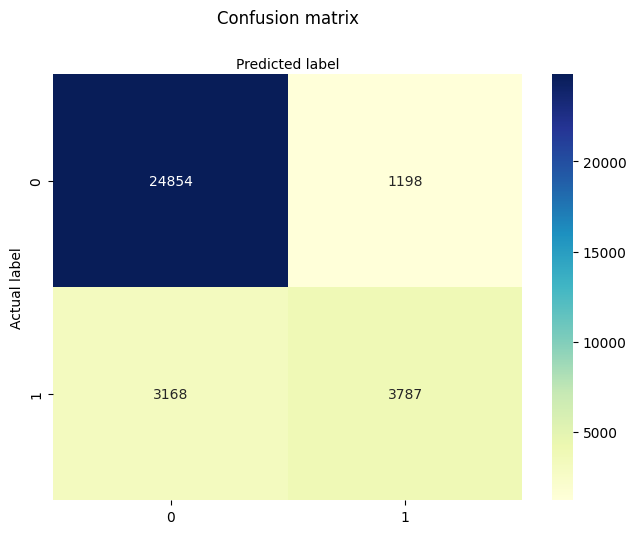

In [65]:
# Making the AUROC curve
import sklearn.metrics as metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_test)

class_names=[0,1] # Names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')